# Satellite Acquisition

**BEFORE RUNNING THIS CODE: **Download the launch 12 GPS data [here](https://github.com/psas/Launch-12/blob/gh-pages/data/GPS/JGPS%40-32.041913222), and place it in the */resources* folder.

This notebook demonstrates the satellite acquisition proccess, in which we determine which satellites are overhead. This code implements the parallel code phase search algorithm, which is the most complex of those available, but is also the fastest since it returns a result in just one iteration. It is possible that we will need to use a different algorithm when the code is running on an embedded platform.

As noted in the L-12 GPS data README, the sampling frequency is 4.092 MHz. and the IF is 0. Also note that the L1 signal hits the antenna at the 1.57542 GHz frequency (10.23 MHz x 154). This is dealt with by the hardware frontend, so we only have to concern ourselves with the 1.023 MHz BPSK modulated C/A code.

**Note: we should only perform this acquisition method on ~20ms sections of data, see book for details**

## Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import peakutils
import struct
import math

##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode

# Start of ByteToIQPairs Function
def ByteToIQPairs( TheByte ):
    IQPairs = []
    
    # This code reads each of the four pairs of bits from the byte 
    # and determines the sign and magnitude. Then it returns a list 
    # containing two pairs of IQ data as floating point [I1,Q1,I2,Q2].
    # For magnitude: a bit value of 1 means mag 1, 0 means mag 1/3
    # For sign: a bit value of 1 means negative, 0 means positive
    # This interpretation was taken by the sample code provided
    # in the PSAS Launch12 github repo (example was provided in C)
    #
    # f_s = 4.092 MHz (sampling rate of raw signal)
   
    IMag1 = (TheByte >> 7) & (0b00000001)
    ISign1 = (TheByte >> 6) & (0b00000001)
    I1 = 1.0 if (IMag1 == 1) else 1.0/3.0
    I1 = -I1 if (ISign1 == 1) else I1
    IQPairs.append(I1)
    
    QMag1 = (TheByte >> 5) & (0b00000001)
    QSign1 = (TheByte >> 4) & (0b00000001)
    Q1 = 1.0 if (QMag1 == 1) else 1.0/3.0
    Q1 = -Q1 if (QSign1 == 1) else Q1
    IQPairs.append(Q1)    
        
    IMag2 = (TheByte >> 3) & (0b00000001)
    ISign2 = (TheByte >> 2) & (0b00000001)
    I2 = 1.0 if (IMag2 == 1) else 1.0/3.0
    I2 = -I2 if (ISign2 == 1) else I2
    IQPairs.append(I2)    
        
    QMag2 = (TheByte >> 1) & (0b00000001)
    QSign2 = (TheByte >> 0) & (0b00000001)
    Q2 = 1.0 if (QMag2 == 1) else 1.0/3.0
    Q2 = -Q2 if (QSign2 == 1) else Q2
    IQPairs.append(Q2)
    
    return IQPairs 
# End of ByteToIQPairs Function


## Import data File

- Information on file "JGPS@-32.041913222" can be found at: https://github.com/psas/Launch-12/tree/gh-pages/data/GPS

In [2]:

print("Opening a file.")
fHandle = open('../resources/JGPS@-32.041913222','r', encoding = 'utf-8', errors = 'ignore')
print("File handle is: %d." % (fHandle.fileno()))

# Read file one byte at a time, extract the two 
# IQ pairs, and store in array, after conversion to float.
# Will initially read enough samples for ~20 ms of data
fs = 4.092*10**6 # Sampling Frequency [Hz]
Ts = 1/fs # Sampling Period [s]
NumberOfMilliseconds = 1
SampleLength = NumberOfMilliseconds*10**(-3) # Sample length in 1ms multiples
StartingByte = 0 # Can change this if we want to discard initial samples
TotalSamples = int(np.ceil(SampleLength/Ts)) 
TotalBytes = int(np.ceil(TotalSamples/2))
print("Total Samples to read: %d"%(TotalSamples))
print("Total Bytes read: %d." %(TotalBytes))
print("Which equals %d IQ pairs." %(TotalBytes*2))
print("Sample Length: %f seconds." %(TotalBytes*2*Ts))

i = StartingByte
SingleByte = fHandle.read(1)
IData = []
QData = []
while SingleByte != "":
    IQPairs = ByteToIQPairs(ord(SingleByte))
    IData.append(IQPairs[0])
    IData.append(IQPairs[2])
    QData.append(IQPairs[1])
    QData.append(IQPairs[3])
    #print("I: %f, Q: %f ." % (IQPairs[0], IQPairs[1]))
    #print("I: %f, Q: %f ." % (IQPairs[2], IQPairs[3]))
    
    i += 1
    if i >= (TotalBytes - StartingByte):
        break
    SingleByte = fHandle.read(1)

fHandle.close()
print("File is now closed.")

Opening a file.
File handle is: 49.
Total Samples to read: 4092
Total Bytes read: 2046.
Which equals 4092 IQ pairs.
Sample Length: 0.001000 seconds.
File is now closed.


# LO Sweep

- Between these 2 steps we need to sweep the local oscillator due to Doppler effect
- Pick a frequency, and run the steps from here assuming the Doppler shift puts us @ that freq
- We need to multiply the incoming data by a complex sine wave 
- The frequency of the generated wave is equal to the difference between the actual and target frequencies
- The sine wave must be complex in order to get a negative frequency (sweep both directions)
- Book recommends +/- 10kHz in 500Hz steps (pg 77)

In [3]:
#Test doppler shift
#np.exp(2*np.pi*1j*-1581) #Is this a scalar? (Bad)
#CData = CData * 

#Make a 1.023MHz carrier
#carriert = np.linspace(0, 81837/4.092e6, 81838)
#Icarrier = np.sin(2 * np.pi * 1.023e6 * carriert) #+ 1j * np.sin()
#Qcarrier = np.cos(2 * np.pi * 1.023e6 * carriert)

#plt.plot(carriert[0:50], Icarrier[0:50])
#plt.plot(carriert[0:50], Qcarrier[0:50])

#plt.show()

# Convert to complex array

Data needs to be in the form: $I(t) + jQ(t)$

In [4]:
print("length of IData is: %d" % (len(IData)))
print("Length of QData is: %d" % (len(QData)))

CData = np.zeros(len(IData), dtype=np.complex)

for d in range(len(IData)):
    CData[d] = IData[d]  + QData[d] * 1j  # Complex data
	#CData[d] = IData[d] * Icarrier[d] + QData[d] * 1j * Qcarrier[d] # Complex data w/LO (maybe)
    
#print(CData)

length of IData is: 4092
Length of QData is: 4092


## Check out the imported data

We will plot the first 100 samples to see what the signal looks like.

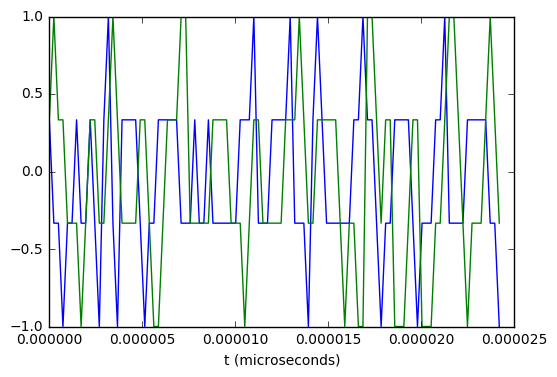

In [5]:
scale = 1/4.092e6
x = np.linspace(0,99,100)
x = x * scale

plt.plot(x, np.real(CData[0:100]))
plt.plot(x, np.imag(CData[0:100]))

#plt.plot(np.real(CData))
#plt.plot(np.imag(CData))

plt.xlabel("t (microseconds)")
plt.show()

# Take fft

We need to take the fft of the IQ datastream.

In [6]:
# Since we are using circular-convolution, nfft must be equal to the number of samples
nfft = TotalSamples
print("Calculated deltaFreq: %f [Hz]" %(fs/nfft))

# Generate frequency lists for plotting fft
# Can use f for regular fft and fshift for shifted version
fs_kHz = fs/1000 #Make easier to read
f = np.linspace (0,fs_kHz,nfft, endpoint=False)
fshift = np.linspace(-fs_kHz/2,fs_kHz/2,nfft,endpoint=False)


# Reference data size section of book to pick the len param. Should be based sample rate
ffC = np.fft.fft(CData, nfft)

Calculated deltaFreq: 1000.000000 [Hz]


# Plot output

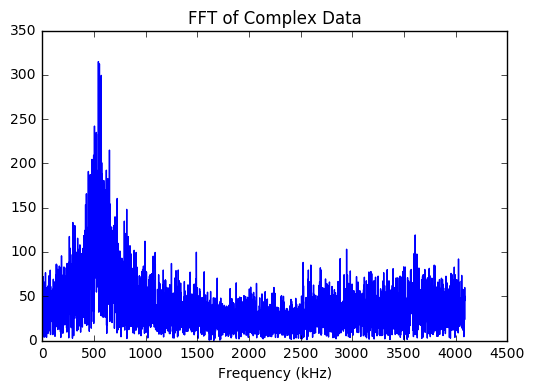

In [7]:
plt.plot(f, np.abs(ffC))

plt.title("FFT of Complex Data")
plt.xlabel("Frequency (kHz)")
plt.show()

# Get a Gold Code

- Gold Code must be generated as though it were sampled at the sampling rate
- 1023 chips that must take 1ms to pass through (due to chipping rate)
- We are sampling @ 4.092 MHz
- So we need the GC to repeat each chip 4 times before going to the next chip.
- The numpy.repeat() function does this exactly

## SVs in this data:

#SV| Doppler(Hz)| Alt (deg)| Az (deg)
---|------------|----------|--------
13 |     3195   | 23.3| 216.5
11 |     3097   |  5.8|  39.0
28 |     1581   | 43.4|  76.3
17 |      359   | 80.6|  80.1
12 |    -2825   |  5.6| 277.7
15 |     1994   | 25.7| 255.4
01 |     1797   | 19.3|  44.4
24 |    -2592   | 31.9| 309.6
30 |     3378   | 13.4| 141.2
06 |    -3321   | 21.1| 159.8

In [8]:
#code = np.repeat(CodeGen.getCode(1023), 4)

#Choose which satellite's C/A code is generated
Satellite = 2

# Create list of C/A code Taps, for simpler sat selection",
#sat = [(2,6),(3,7),(4,8),(5,9),(1,9),(2,6),(1,8),(2,9),(3,10),(2,3),(3,4),(5,6),(6,7),(7,8),(8,9),(9,10),(1,4),(2,5),(3,6),(4,7),(5,8),(6,9),(1,3),(4,6),(5,7),(6,8),(7,9),(8,10),(1,6),(2,7),(3,8),(4,9),(5,10),(4,10),(1,7),(2,8),(4,10)]
sat = [(1,5),(2,6),(3,7),(4,8),(0,8),(1,5),(0,7),(1,8),(2,9),(1,2),(2,3),(4,5),(5,6),(6,7),(7,8),(8,9),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(0,2),(3,5),(4,6),(5,7),(6,8),(7,9),(0,5),(1,6),(2,7),(3,8),(4,9),(3,9),(0,6),(1,7),(3,9)]

# Create Code Generator object for chosen Satellite
CodeGen = GoldCode(sat[Satellite - 1]) # Index starts at zero

# Generate CA Code
CACode = CodeGen.getCode(1023)

# Reformat GC to have -1 in place of 0
for n,i in enumerate(CACode):
    if i==0:
        CACode[n]=-1
        
# Repeat each chip 4 times (See markdown in above cell), to match our ADC sample frequency",
CACodeSampled = np.repeat(CACode,4)
print("Satellite chosen: %d, with tap: %s" %(Satellite,str(sat[Satellite - 1])))

# Repeat entire array for each ms of data sampled
CACodeSampled = np.tile(CACodeSampled,NumberOfMilliseconds)
print(len(CACodeSampled))

Satellite chosen: 2, with tap: (2, 6)
4092


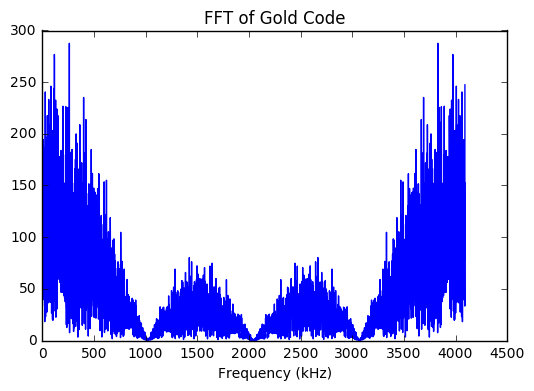

In [9]:
Codefft = np.fft.fft(CACodeSampled, nfft)

plt.plot(f, np.abs(Codefft))
plt.title("FFT of Gold Code")
plt.xlabel("Frequency (kHz)")
plt.show()

# Complex Conjugate of Gold Code fft

Take the complex conjugate of the Gold Code [real(fft) - imag(fft)j], and then multiply it by the IQ fft. If this is done correctly there should be a spike about $10^7$ times as high as the noise. 



Length of t: 4092
Length of IFFT: 4092


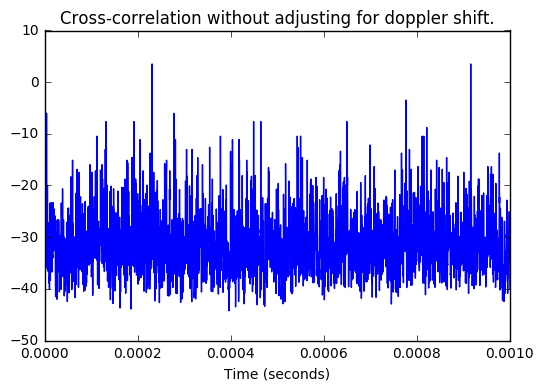

Max Value: 3.521825, at freqshift: 0, with index 943


In [10]:
GCConj = np.conjugate(Codefft)

result = np.fft.ifft(GCConj * ffC,nfft)

resultSQ = np.abs(result) ** 2
resultLog = -10*np.log10(resultSQ)

t = np.linspace(0,SampleLength,nfft,endpoint=True) 
print("Length of t: %d" %(len(t)))
print("Length of IFFT: %d" %(len(resultSQ)))

plt.plot(t,resultLog)
plt.title("Cross-correlation without adjusting for doppler shift.")
plt.xlabel("Time (seconds)")
plt.show()

print("Max Value: %f, at freqshift: %d, with index %d"%(np.max(resultLog),0,np.argmax(resultLog)))

# Notes

- From book appendix: we should look for the top 2 peaks, and use the ratio to determine whether there is a signal or just noise
- We should get the C code running and be sure to compare results. Acquisition works in the C code, but tracking is untested

## Shift frequency using multiplication by a complex exponential

4092
4092
4092


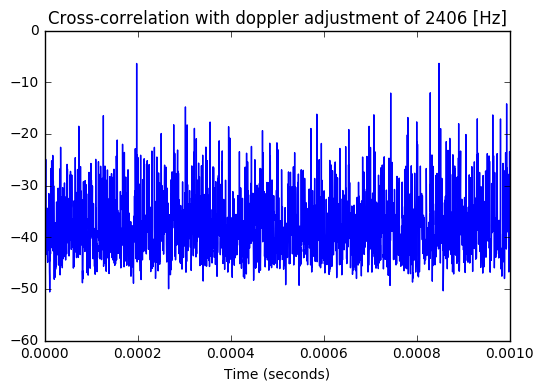

Max Value: -6.366877, at freqshift: 2406, with index: 3467 div/4: 866.750000


In [11]:
freqShift = 2406 #[Hz]

# Initialize complex array
CDataShifted = np.zeros(len(CData), dtype=np.complex)
print(len(CData))
print(len(CDataShifted))
print(len(t))
for i in range(len(CData)):
    CDataShifted[i] = CData[i]*np.exp(1j*2*np.pi*freqShift*t[i]) + CData[i]*np.exp(1j*2*np.pi*freqShift*t[i])
    
fftCDataShifted = np.fft.fft(CDataShifted,nfft)

result = np.fft.ifft(GCConj * fftCDataShifted,nfft)

resultSQ = np.abs(result) ** 2
resultLog = -10*np.log10(resultSQ)

plt.plot(t,resultLog)
plt.title("Cross-correlation with doppler adjustment of %d [Hz]"%(freqShift))
plt.xlabel("Time (seconds)")
plt.show()

print("Max Value: %f, at freqshift: %d, with index: %d div/4: %f"%(np.max(resultLog),freqShift,np.argmax(resultLog),np.argmax(resultLog)/4))

4092
4092


/home/eric/.local/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


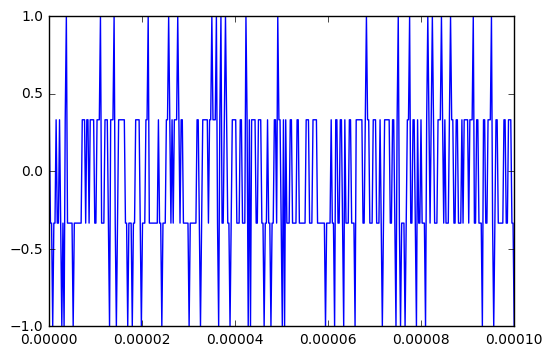

In [12]:
# Shift gold code by maximum index from prior cell
CACode_Shifted = CACodeSampled
np.roll(CACode_Shifted,np.argmax(resultLog))

print(len(CData))
print(len(CACode_Shifted))
# Multiply by frequency shifted complex data: 
Result = np.zeros(len(CData), dtype=np.complex)
for i in range(len(CData)):
    Result[i] = CACode_Shifted[i]*CData[i]

plt.plot(t,Result)
plt.xlim(0,0.0001)
plt.show()

In [13]:
t

array([  0.00000000e+00,   2.44439012e-07,   4.88878025e-07, ...,
         9.99511122e-04,   9.99755561e-04,   1.00000000e-03])

In [14]:

len(t)

4092

## Shift through frequency and satellite range

In [15]:
# Choose what frequencies and satellites to increment over
StartingFrequencyShift = -10*10**3
EndingFrequencyShift = 10*10**3
FrequencyShiftIncrement = 1*10**3
FrequencyList = range(StartingFrequencyShift,EndingFrequencyShift + FrequencyShiftIncrement,FrequencyShiftIncrement)

StartingSatellite = 1
EndingSatellite = 30
SatelliteList = range(StartingSatellite, EndingSatellite + 1)

# Create list of C/A code Taps, for simpler sat selection",
#sat = [(2,6),(3,7),(4,8),(5,9),(1,9),(2,6),(1,8),(2,9),(3,10),(2,3),(3,4),(5,6),(6,7),(7,8),(8,9),(9,10),(1,4),(2,5),(3,6),(4,7),(5,8),(6,9),(1,3),(4,6),(5,7),(6,8),(7,9),(8,10),(1,6),(2,7),(3,8),(4,9),(5,10),(4,10),(1,7),(2,8),(4,10)]
sat = [(1,5),(2,6),(3,7),(4,8),(0,8),(1,5),(0,7),(1,8),(2,9),(1,2),(2,3),(4,5),(5,6),(6,7),(7,8),(8,9),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(0,2),(3,5),(4,6),(5,7),(6,8),(7,9),(0,5),(1,6),(2,7),(3,8),(4,9),(3,9),(0,6),(1,7),(3,9)]

# Create array to store max values, freq ranges, per satellite
SatMax = np.zeros((len(SatelliteList),len(FrequencyList),3))

satInd = 0 
# Loop through selected satellites
for curSat in SatelliteList: 
    # Create Code Generator object for chosen Satellite
    CodeGen = GoldCode(sat[curSat - 1]) # Index starts at zero
    
    # Generate CA Code
    CACode = CodeGen.getCode(1023)
    
    # Reformat GC to have -1 in place of 0
    for n,i in enumerate(CACode):
        if i==0:
            CACode[n]=-1
            
    # Repeat each chip 4 times (See markdown in above cell), to match our ADC sample frequency",
    CACodeSampled = np.repeat(CACode,4)
    #print("Satellite chosen: %d, with tap: %s" %(Satellite,str(sat[Satellite - 1])))
    
    # Repeat entire array for each ms of data sampled
    CACodeSampled = np.tile(CACodeSampled,NumberOfMilliseconds)
    Codefft = np.fft.fft(CACodeSampled,nfft)
    GCConj = np.conjugate(Codefft)
    
    freqInd = 0
    # Loop through all frequencies
    for curFreq in FrequencyList:
        # Initialize complex array
        CDataShifted = np.zeros(len(CData), dtype=np.complex)
        
        # Shift frequency using complex exponential 
        for i in range(len(CData)):
            CDataShifted[i] = CData[i]*np.exp(1j*2*np.pi*curFreq*t[i]) + CData[i]*np.exp(1j*2*np.pi*curFreq*t[i])
        
        fftCDataShifted = np.fft.fft(CDataShifted,nfft)
        
        result = np.fft.ifft(GCConj * fftCDataShifted,nfft)
        
        resultSQ = np.abs(result) ** 2
        resultSQ = np.real(resultSQ)
        maxAbsSquared = np.max(resultSQ)
        
        resultLog = 10*np.log10(resultSQ)
        maxdB = np.max(resultLog)
        
        print("Sat: %d, Doppler Shift: %8.2f, MaxVal: %8.2f, MaxVal (dB): %8.4f" %(curSat,curFreq, maxAbsSquared, maxdB))
        
        # Store results in array
        SatMax[satInd,freqInd,0] = maxAbsSquared
        SatMax[satInd,freqInd,1] = maxdB
        SatMax[satInd,freqInd,2] = np.real(np.sum(resultLog))
        freqInd = freqInd + 1
    satInd = satInd+1



Sat: 1, Doppler Shift: -10000.00, MaxVal: 107939.06, MaxVal (dB):  50.3318
Sat: 1, Doppler Shift: -9000.00, MaxVal: 115436.94, MaxVal (dB):  50.6234
Sat: 1, Doppler Shift: -8000.00, MaxVal: 104746.81, MaxVal (dB):  50.2014
Sat: 1, Doppler Shift: -7000.00, MaxVal: 129969.43, MaxVal (dB):  51.1384
Sat: 1, Doppler Shift: -6000.00, MaxVal: 102341.37, MaxVal (dB):  50.1005
Sat: 1, Doppler Shift: -5000.00, MaxVal: 98884.94, MaxVal (dB):  49.9513
Sat: 1, Doppler Shift: -4000.00, MaxVal: 183653.41, MaxVal (dB):  52.6400
Sat: 1, Doppler Shift: -3000.00, MaxVal: 87178.91, MaxVal (dB):  49.4041
Sat: 1, Doppler Shift: -2000.00, MaxVal: 103437.36, MaxVal (dB):  50.1468
Sat: 1, Doppler Shift: -1000.00, MaxVal: 115679.80, MaxVal (dB):  50.6326
Sat: 1, Doppler Shift:     0.00, MaxVal: 124872.89, MaxVal (dB):  50.9647
Sat: 1, Doppler Shift:  1000.00, MaxVal: 102036.86, MaxVal (dB):  50.0876
Sat: 1, Doppler Shift:  2000.00, MaxVal: 105717.31, MaxVal (dB):  50.2415
Sat: 1, Doppler Shift:  3000.00, MaxVal

In [16]:
print(np.argmax(SatMax[0,:,0]))
print(FrequencyList[np.argmax(SatMax[0,:,0])])
print(np.argmax(SatMax[0,:,1]))
print(FrequencyList[np.argmax(SatMax[0,:,1])])
print(np.argmax(SatMax[0,:,2]))
print(FrequencyList[np.argmax(SatMax[0,:,2])])

6
-4000
6
-4000
4
-6000


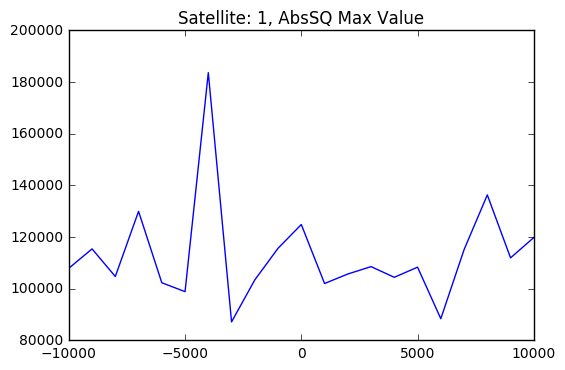

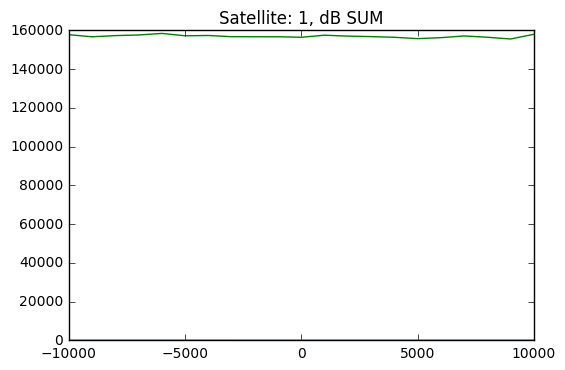

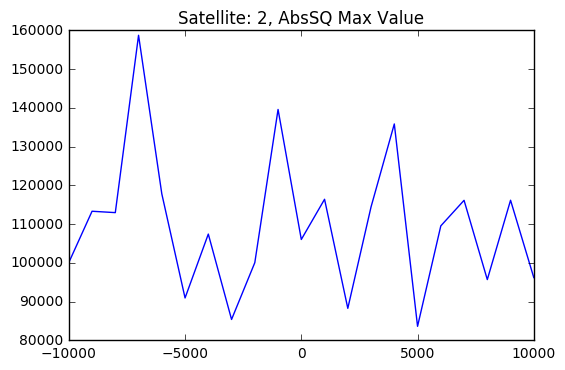

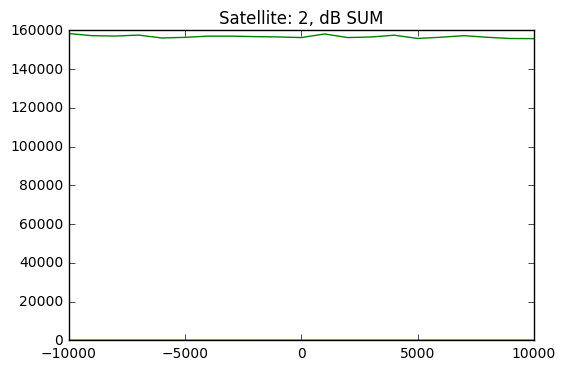

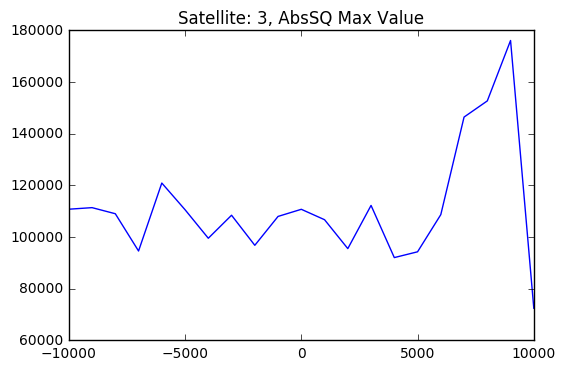

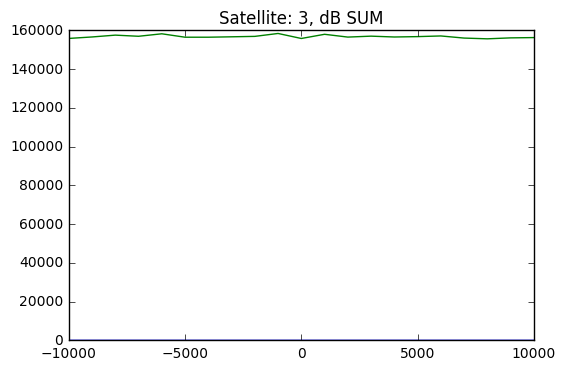

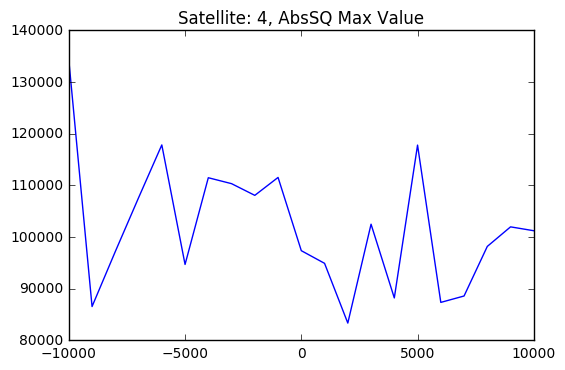

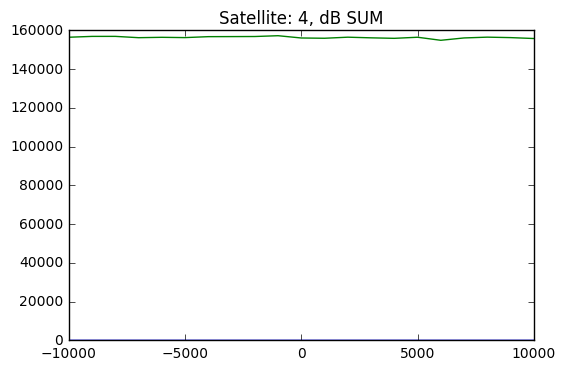

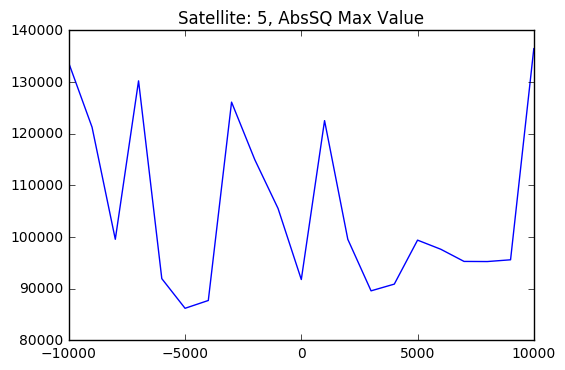

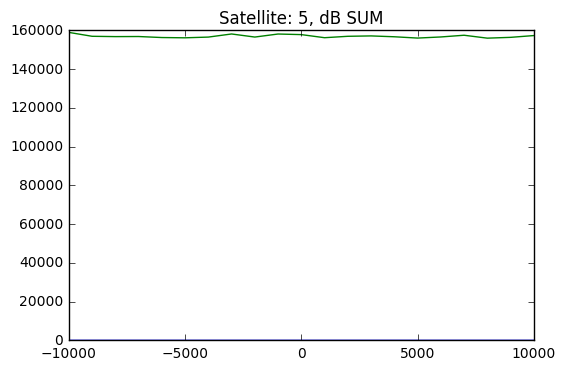

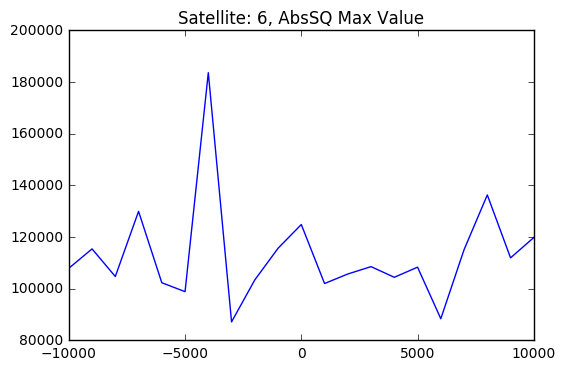

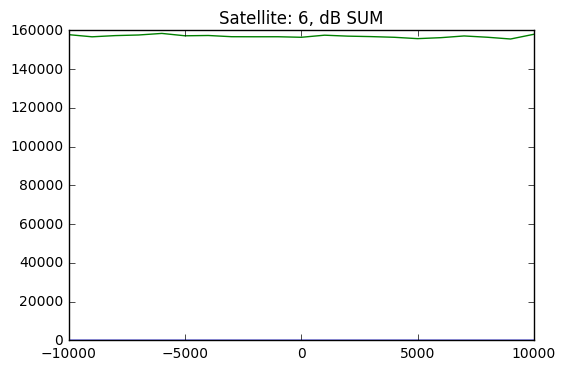

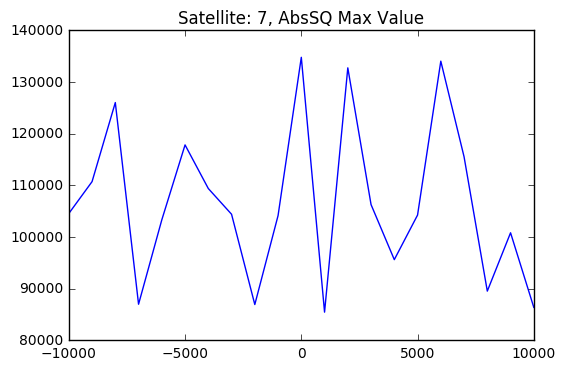

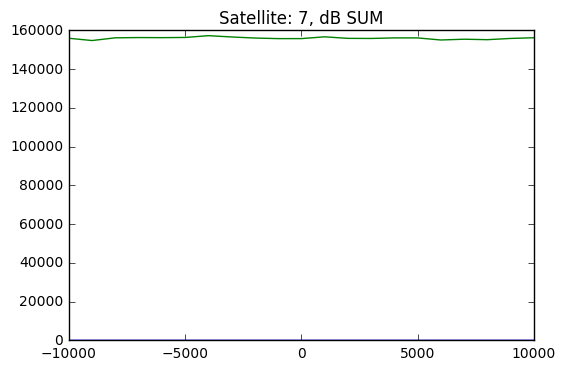

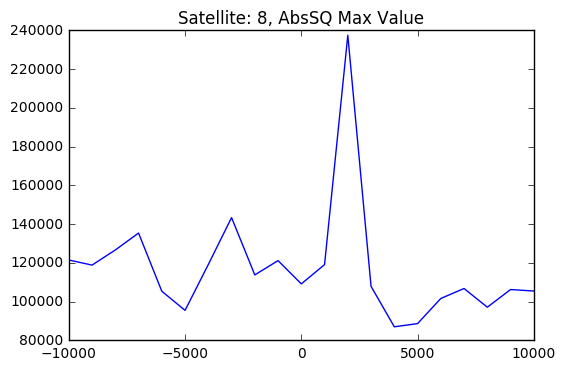

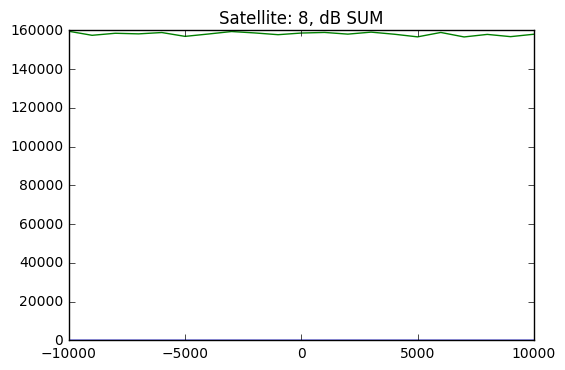

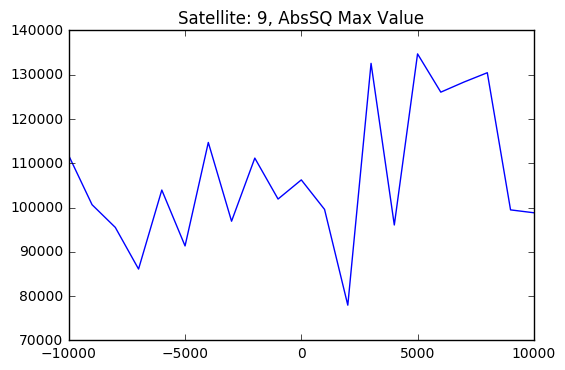

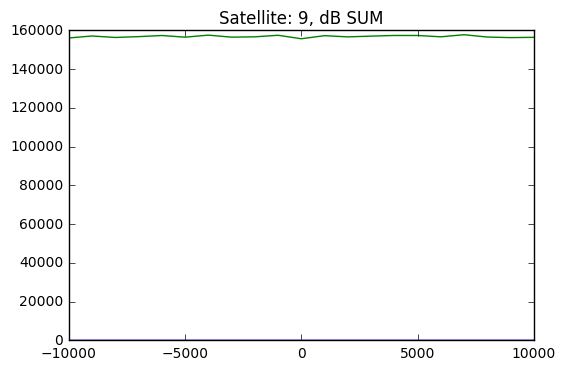

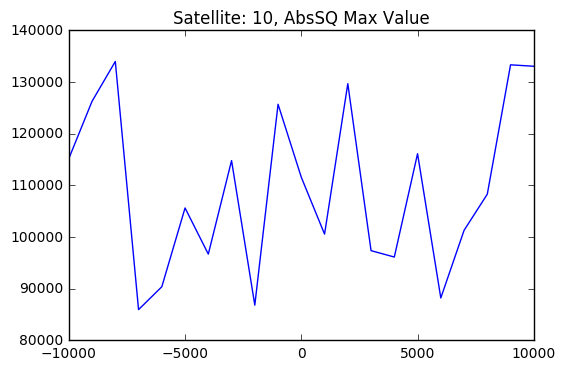

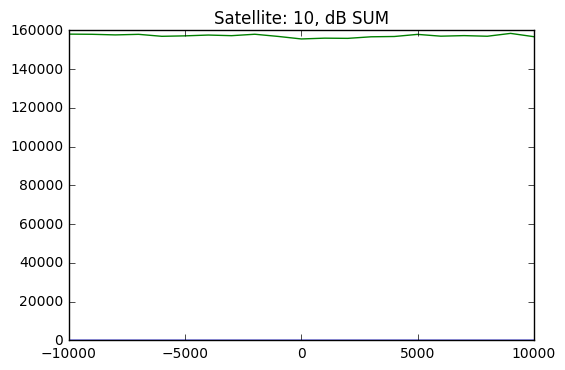

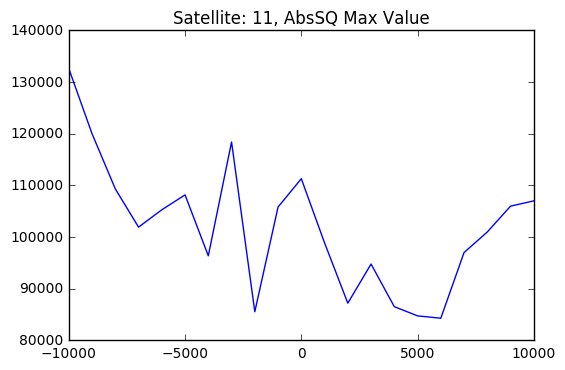

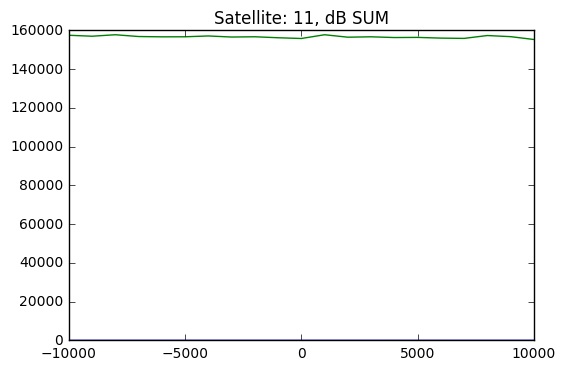

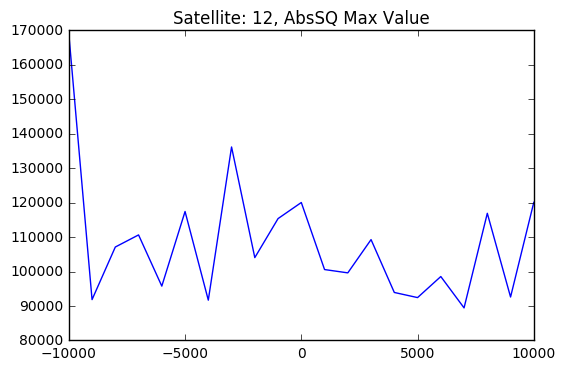

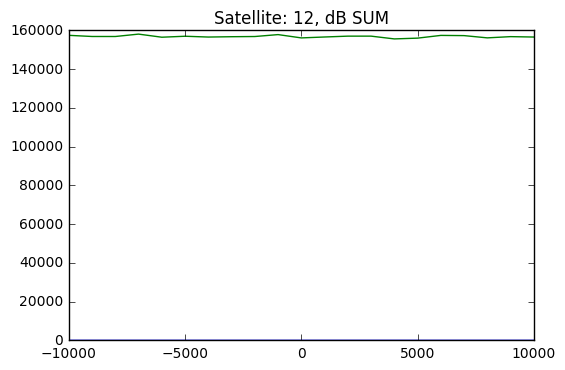

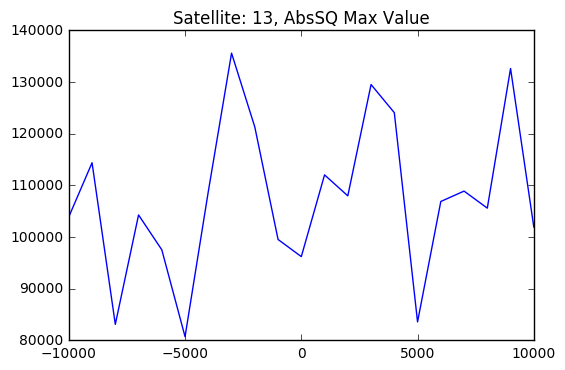

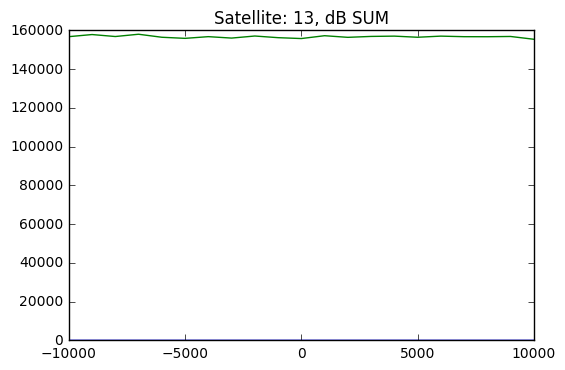

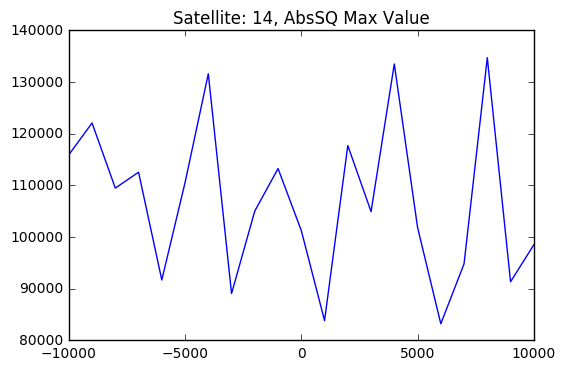

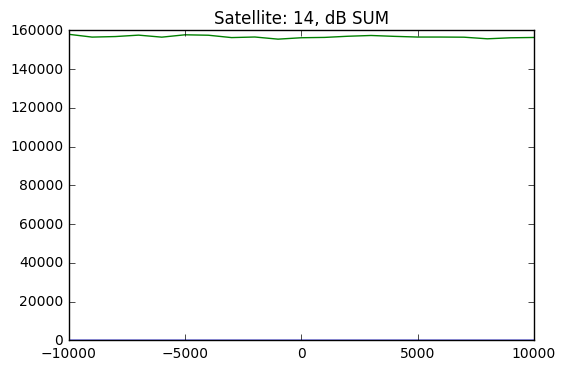

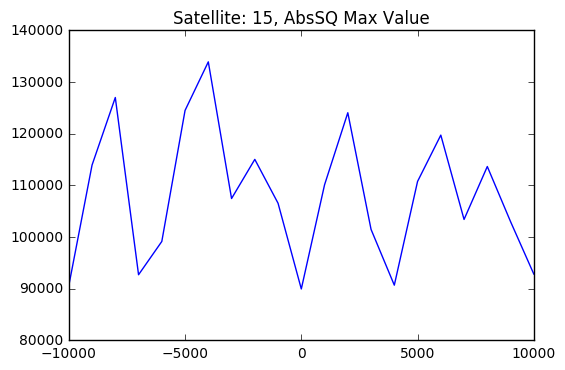

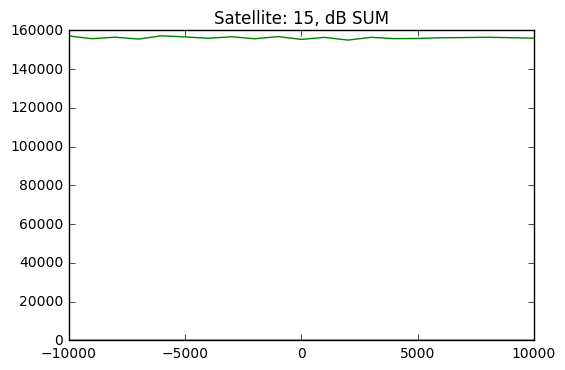

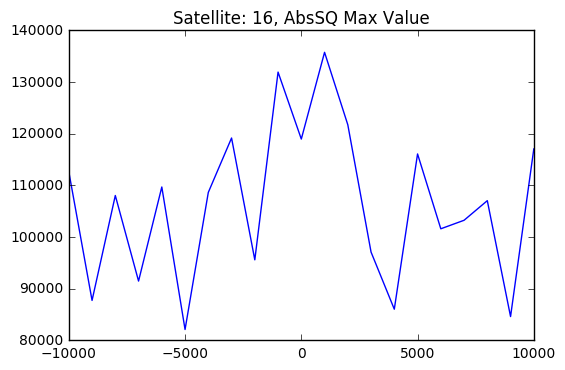

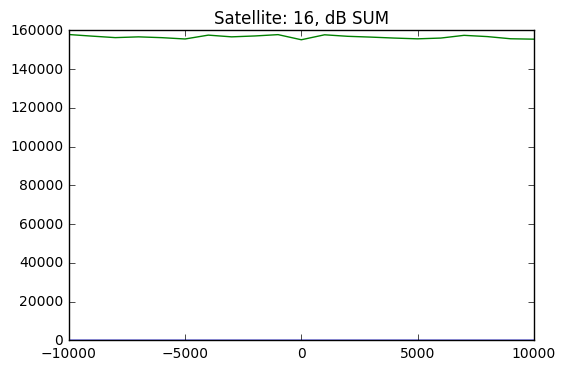

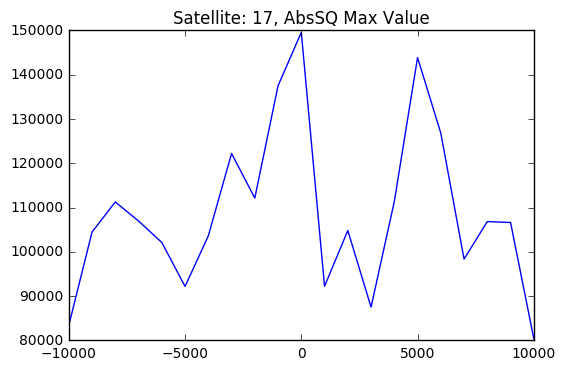

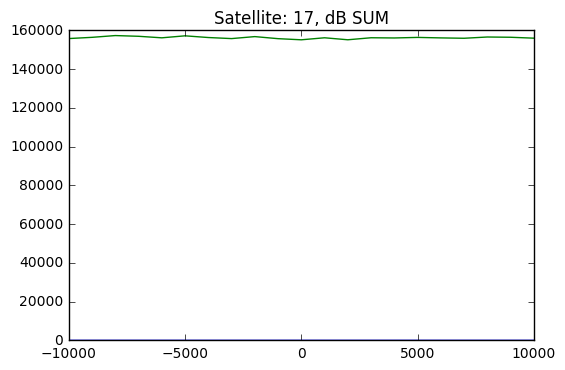

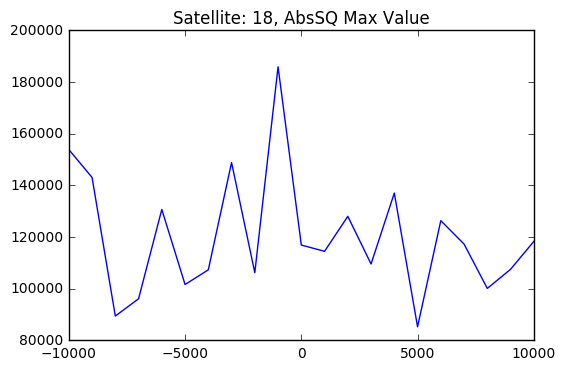

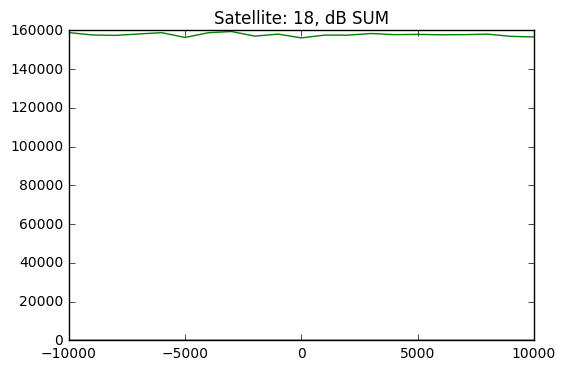

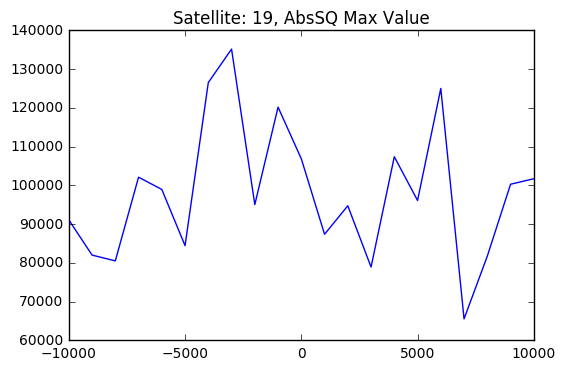

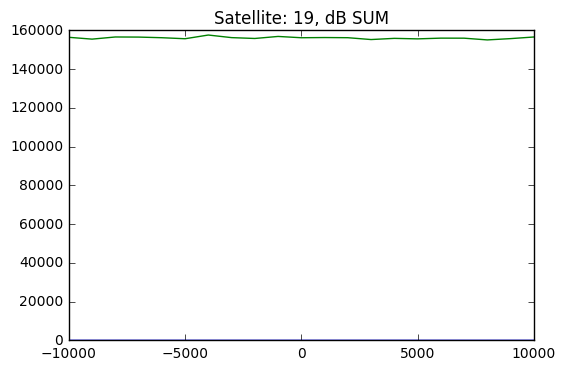

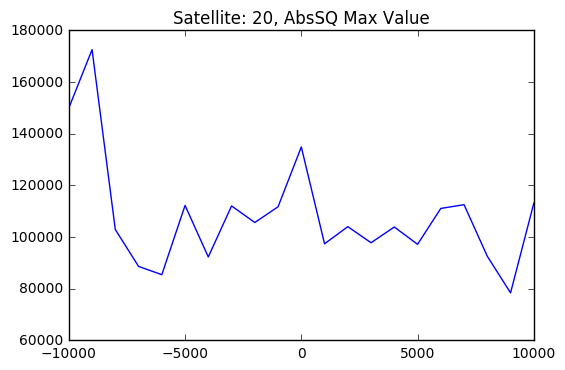

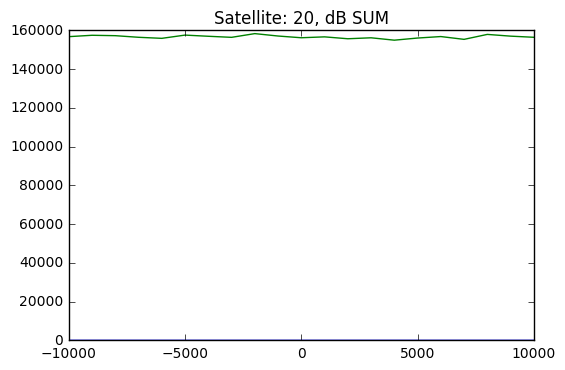

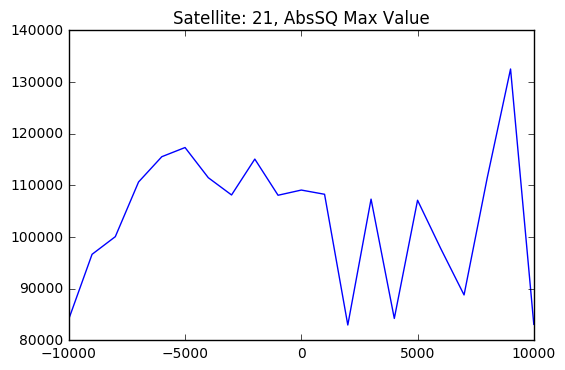

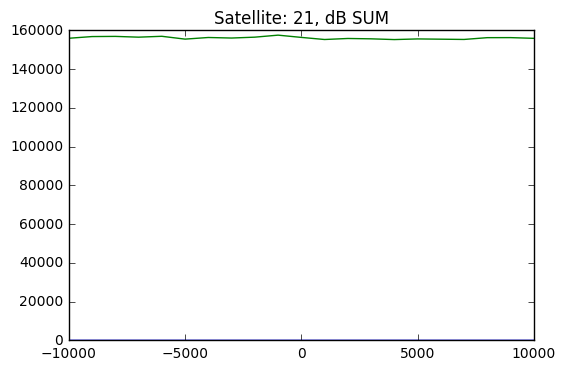

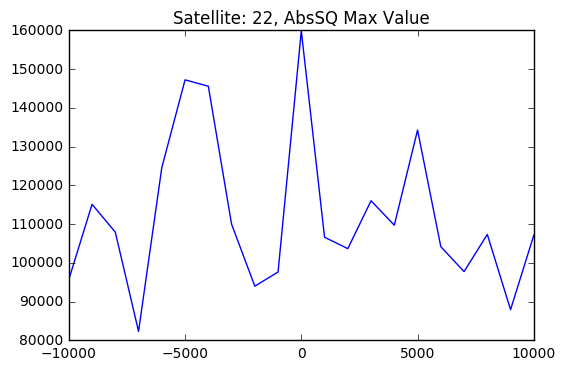

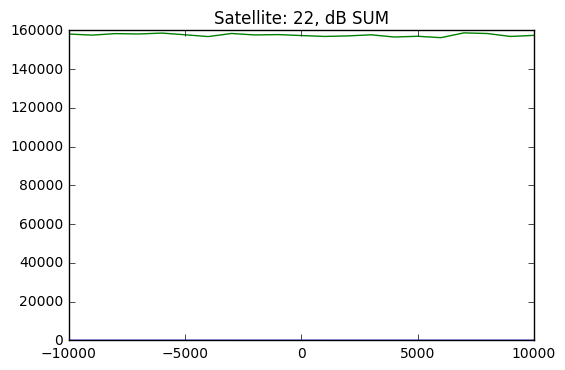

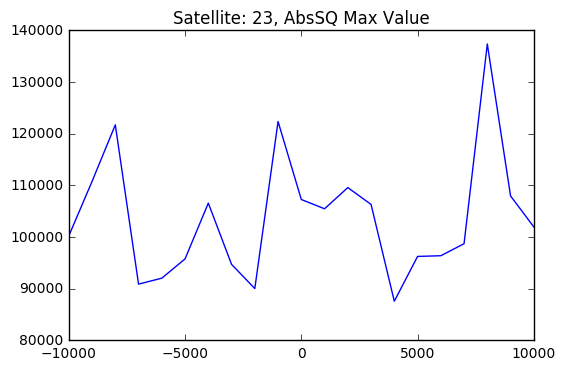

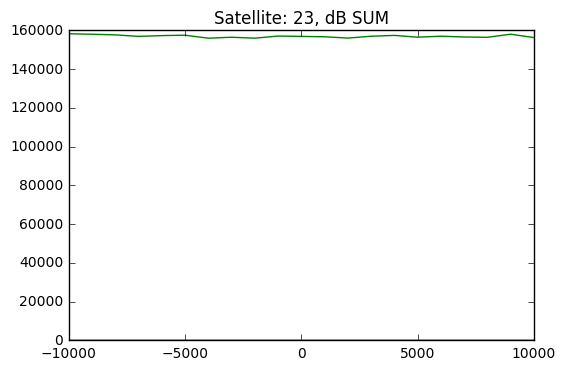

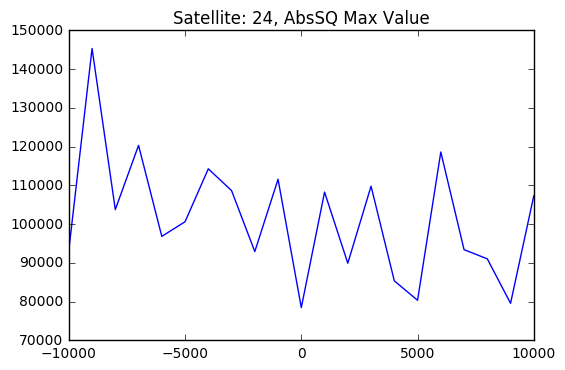

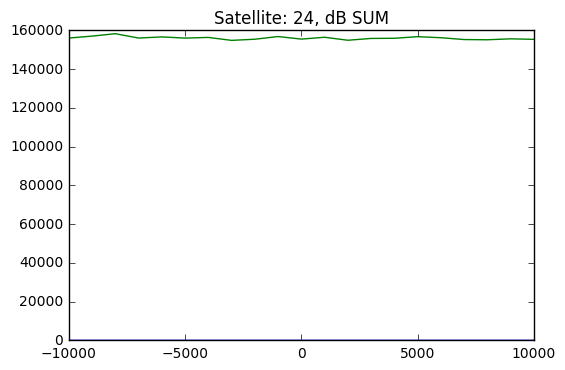

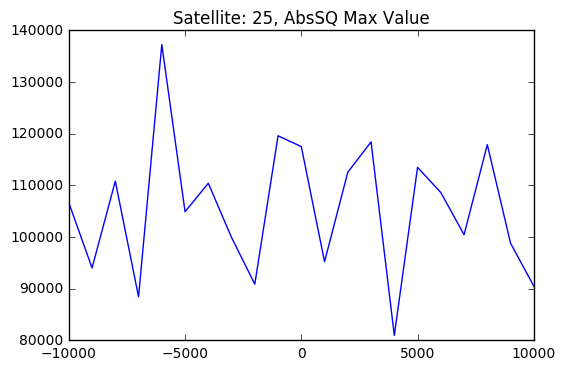

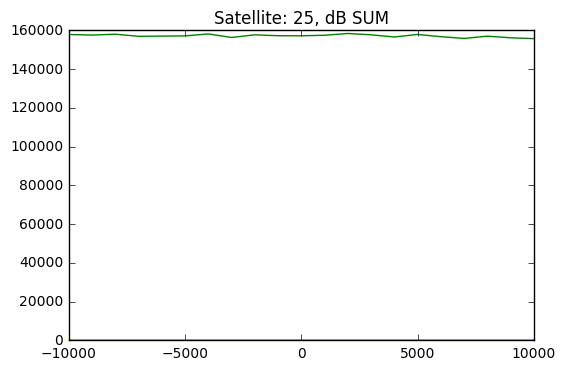

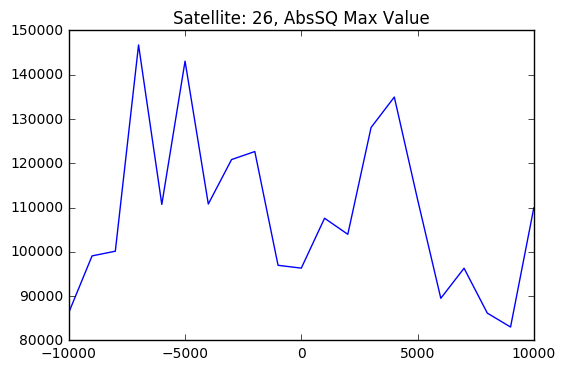

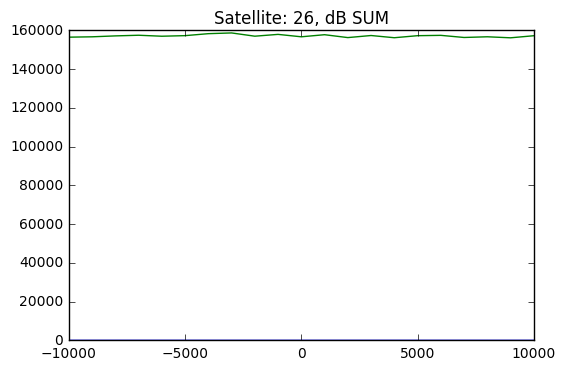

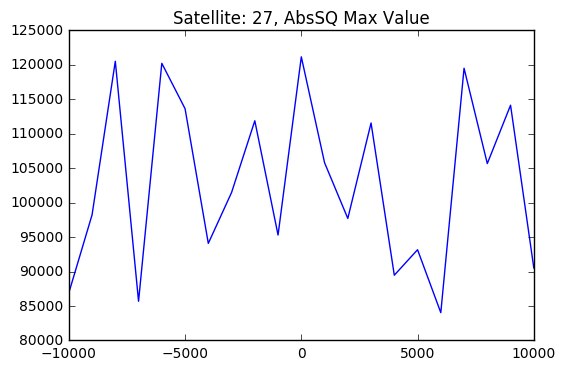

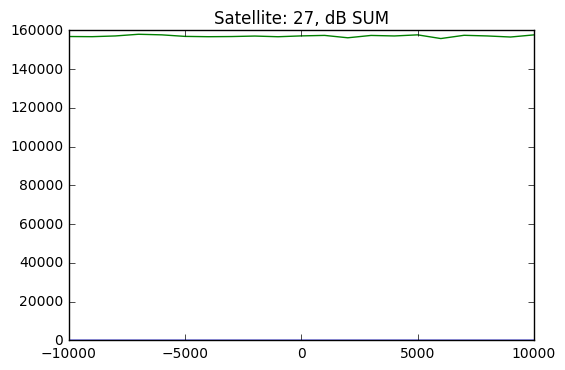

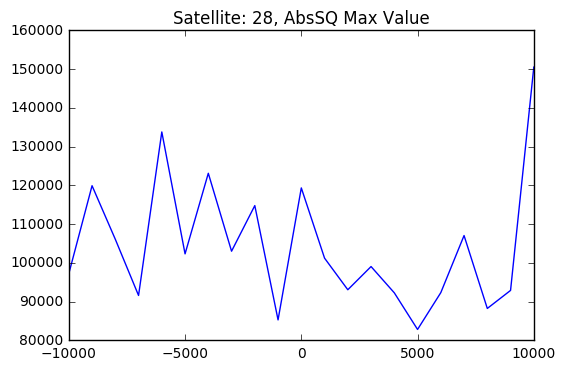

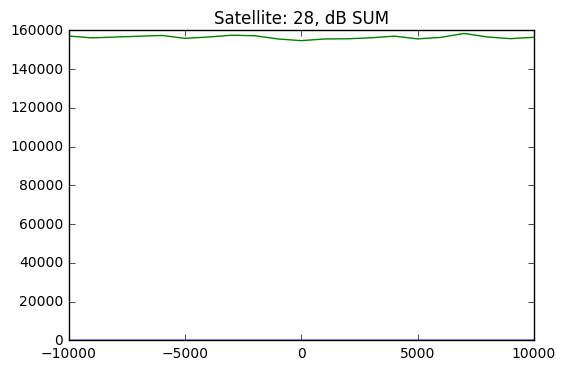

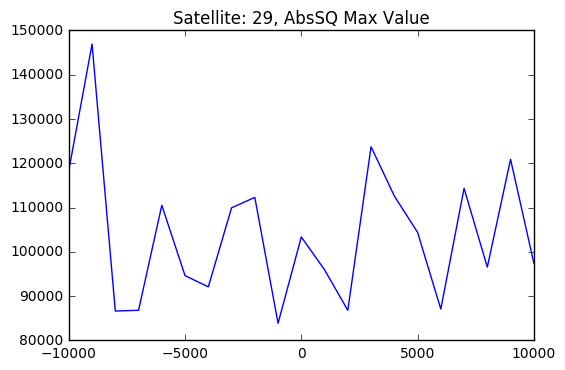

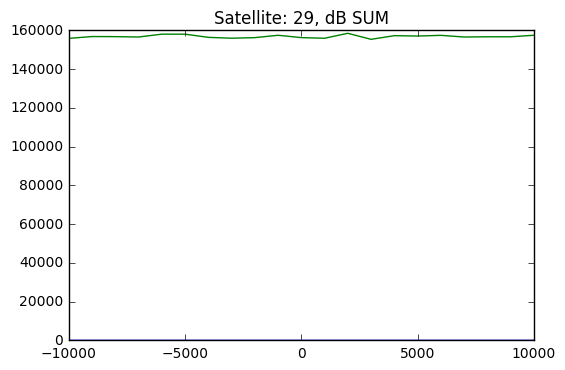

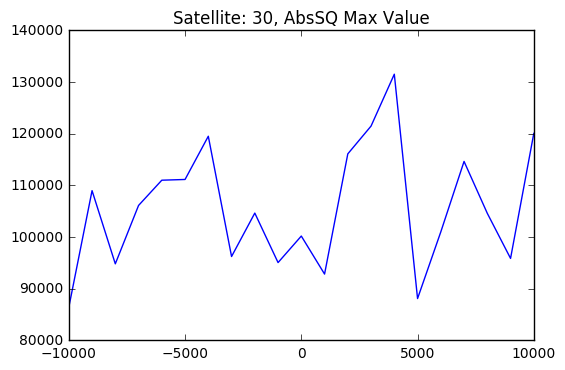

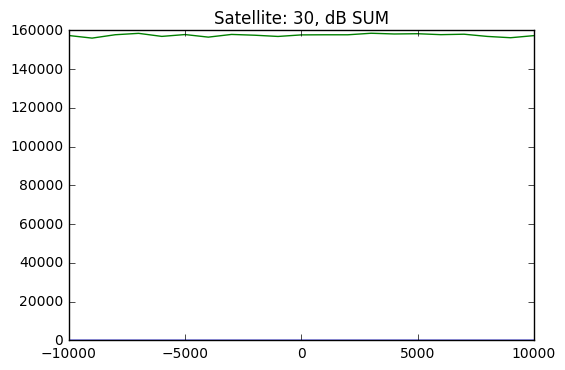

In [17]:
for i in range(StartingSatellite,EndingSatellite+1):
    plt.plot(FrequencyList,SatMax[i-1,:,0])
    plt.title("Satellite: %d, AbsSQ Max Value"%(i))
    plt.show()

    plt.plot(FrequencyList,SatMax[i-1,:,1])
    plt.title("Satellite: %d, dB Max Value"%(i))

    plt.plot(FrequencyList,SatMax[i-1,:,2])
    plt.title("Satellite: %d, dB SUM"%(i))

    plt.show()
